## Chapter 8 - Dimensionality Reduction

Many ML problems involve training on many features for each training instance. This process is slow and makes it harder to find a good solution. This is called the curse of dimensionality. Two ways are discussed - projection & manifold learning.

#### Projection
In most problems, training instances are not spread out uniformly across all dimensions. Some are almost constant while some are highely correlated with each other. Hence, all training instances actually lie within a much lower dimensional subspace of the high dimensional space.

#### Manifold Learning
Manifold learning relies on the manifold assumption, that most real-world high dimensional datasets lie close to a much lower-dimensional manifold. E.g. a Swiss Roll is a 2D manifold. It resembles a 2D space but it is bent and we see a 3D space. Also, we assume that the ML task (regression/classification) will be simpler if expressed in the lower dimensional space of the menifold.

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

import matplotlib.pyplot as plt

def load(fname):
    import pickle
    mnist = None
    try:
        with open(fname, 'rb') as f:
            mnist = pickle.load(f)
            return mnist
    except FileNotFoundError:
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', version=1, cache=True)
        with open(fname, 'wb') as f:
            mnist = pickle.dump(mnist, f)
        return mnist

In [2]:
unn = load('mnist.data.pkl')
X = np.array(unn['data'])
print(X.shape)

(70000, 784)


In [3]:
# Data is 28x28 squares. Attempt to shrink to 14x14 squares
pca = PCA(n_components=14**2)
X_proj1 = pca.fit_transform(X)

In [4]:
# Check the variance ratios of top 20 components
print(pca.explained_variance_ratio_[:50])
print(sum(pca.explained_variance_ratio_[:50]))

[0.09746116 0.07155445 0.06149531 0.05403385 0.04888934 0.04305227
 0.03278262 0.02889642 0.02758364 0.0234214  0.02106689 0.02037553
 0.01707064 0.0169402  0.01583382 0.01486345 0.01319358 0.01279014
 0.01187272 0.01152937 0.0106604  0.01009794 0.00959151 0.00909635
 0.00883287 0.00838818 0.00809832 0.00785718 0.00740262 0.00690014
 0.00656144 0.0064547  0.00600819 0.00585612 0.00566754 0.00543471
 0.00504717 0.00487079 0.00478955 0.00467594 0.00454369 0.00444918
 0.00418217 0.00396164 0.00383708 0.00375785 0.00361426 0.00349025
 0.00338732 0.00319696]
0.8254188388275379


In [5]:
# Choosing the right number of dimensions using 95% explanation
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum[:50])
d = np.argmax(cumsum>0.95)+1
print(d)

[0.09746116 0.16901561 0.23051091 0.28454476 0.3334341  0.37648637
 0.40926898 0.4381654  0.46574904 0.48917044 0.51023733 0.53061286
 0.5476835  0.5646237  0.58045752 0.59532097 0.60851456 0.6213047
 0.63317742 0.64470679 0.65536719 0.66546513 0.67505665 0.684153
 0.69298586 0.70137405 0.70947236 0.71732954 0.72473217 0.73163231
 0.73819375 0.74464845 0.75065664 0.75651276 0.7621803  0.767615
 0.77266217 0.77753297 0.78232252 0.78699846 0.79154214 0.79599132
 0.80017349 0.80413513 0.8079722  0.81173005 0.81534432 0.81883456
 0.82222188 0.82541884]
154


In [6]:
# Fitting now with 95% explained variance from earlier.
pca2 = PCA(n_components=0.95)
pca2.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
# Gets the same result
print(len(pca2.components_))

154


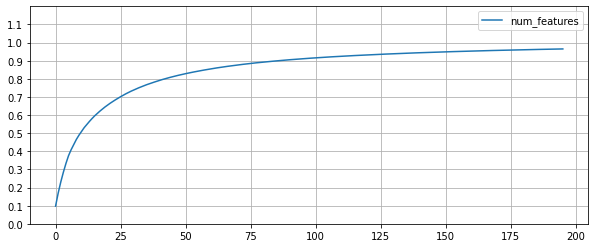

In [26]:
# Or use the elbow curve to help determine the no. of dimensions to use.
fig, ax = plt.subplots(figsize=(18,10))
pd.DataFrame({'num_features' : cumsum}).plot(kind='line', y='num_features', figsize=(10,4), ax=ax)
ax.set_ylim(0,1.2)
ax.set_yticks([i/10 for i in range(0,12)])
ax.grid()
plt.show()

In [9]:
# Incremental PCA
n_batches = 100
incpca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X, n_batches):
    incpca.partial_fit(X_batch)


In [10]:
# Transform using the projection learnt after the incremental PCA
X_proj3 = incpca.transform(X)

In [11]:
# Randomised PCA
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_proj4 = rnd_pca.fit_transform(X)